# Galaxy Classification using Deep Learning
## Using astroNN Dataset

In [12]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from astroNN.datasets import load_galaxy10
from collections import Counter

In [3]:
# Create directory and download dataset
if not os.path.exists('galaxy_data'):
    os.makedirs('galaxy_data')

# Download and save the dataset locally if not already downloaded
if not os.path.exists('galaxy_data/images.npy') or not os.path.exists('galaxy_data/labels.npy'):
    print("Downloading and saving dataset...")
    images, labels = load_galaxy10()
    np.save('galaxy_data/images.npy', images)
    np.save('galaxy_data/labels.npy', labels)
    del images, labels  # Free up memory
    print("Dataset saved successfully!")

Galaxy10_DECals.h5: 100%|█████████▉| 2.74G/2.74G [20:35<00:00, 1.26MB/s]    

Downloaded Galaxy10 successfully to C:\Users\seifk\.astroNN\datasets\Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [20:37, 2.21MB/s]                            


Dataset saved successfully!


In [3]:
images = np.load('galaxy_data/images.npy', mmap_mode='r')
labels = np.load('galaxy_data/labels.npy')

In [4]:
unique_classes = np.unique(labels)
num_classes = len(unique_classes)
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 10


In [5]:
class_counts = Counter(labels)
print("Number of images in each class:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} images")

Number of images in each class:
Class 0: 1081 images
Class 1: 1853 images
Class 2: 2645 images
Class 3: 2027 images
Class 4: 334 images
Class 5: 2043 images
Class 6: 1829 images
Class 7: 2628 images
Class 8: 1423 images
Class 9: 1873 images


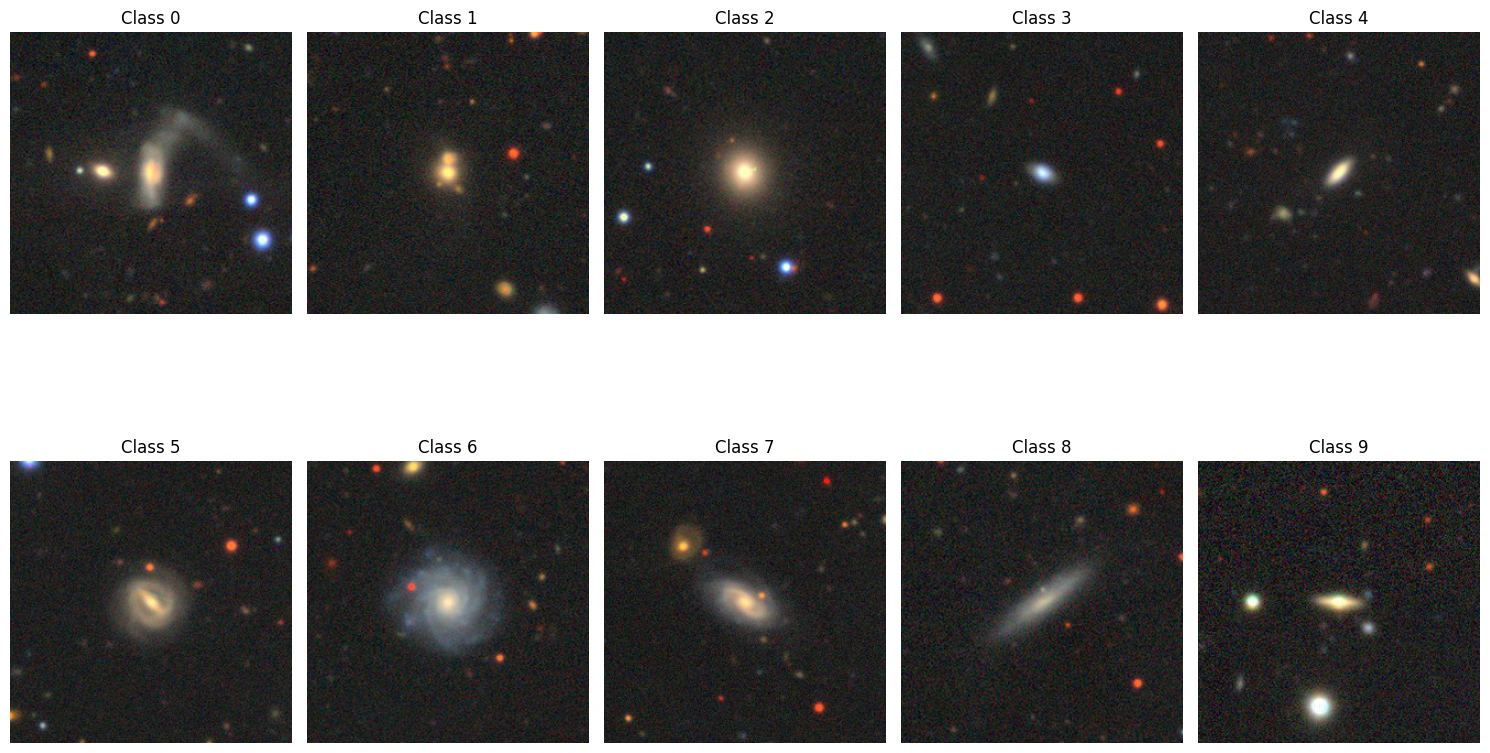

In [13]:
def plot_sample_images(images, labels, unique_classes, num_classes):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(unique_classes):
        # Find the index of the first image in this class
        class_idx = np.where(labels == cls)[0][0]
        plt.subplot(2, (num_classes + 1) // 2, i + 1)
        plt.imshow(images[class_idx])
        plt.title(f"Class {cls}")  # Display class index
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(images, labels, unique_classes, num_classes)

In [9]:
# Create data generator class
class GalaxyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_path, labels_path, batch_size=32, shuffle=True):
        self.images = np.load(images_path, mmap_mode='r')  # Memory-mapped mode
        self.labels = np.load(labels_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.labels))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.images[batch_indexes].astype('float32') / 255.0
        batch_labels = to_categorical(self.labels[batch_indexes], num_classes=10)
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [5]:
# Prepare train and validation splits
if not os.path.exists('galaxy_data/train_images.npy'):
    print("Preparing train/validation split...")
    # Create train/test split indexes
    all_indexes = np.arange(len(np.load('galaxy_data/labels.npy')))
    train_idx, val_idx = train_test_split(all_indexes, test_size=0.2, random_state=42)

    # Save split indexes
    np.save('galaxy_data/train_idx.npy', train_idx)
    np.save('galaxy_data/val_idx.npy', val_idx)

    # Create separate files for train and validation sets
    images = np.load('galaxy_data/images.npy', mmap_mode='r')
    labels = np.load('galaxy_data/labels.npy')

    np.save('galaxy_data/train_images.npy', images[train_idx])
    np.save('galaxy_data/train_labels.npy', labels[train_idx])
    np.save('galaxy_data/val_images.npy', images[val_idx])
    np.save('galaxy_data/val_labels.npy', labels[val_idx])

    del images, labels  # Free up memory
    print("Split completed and saved!")

# Data generators
train_generator = GalaxyDataGenerator(
    'galaxy_data/train_images.npy',
    'galaxy_data/train_labels.npy',
    batch_size=32
)

val_generator = GalaxyDataGenerator(
    'galaxy_data/val_images.npy',
    'galaxy_data/val_labels.npy',
    batch_size=32
)

Preparing train/validation split...
Split completed and saved!


---

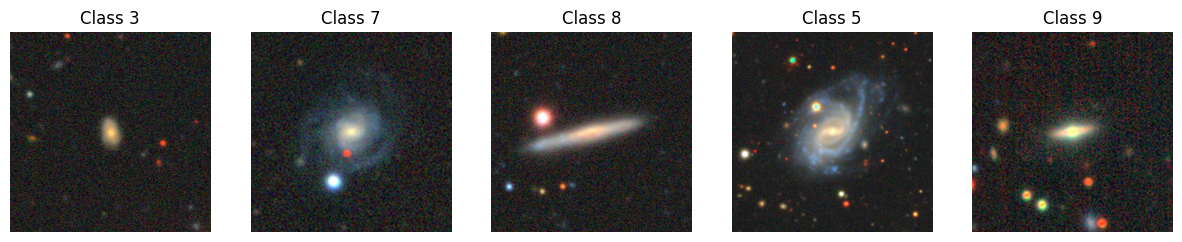

In [6]:
# Visualize sample images
def plot_sample_images(generator, num_images=5):
    images, labels = generator.__getitem__(0)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f'Class {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

plot_sample_images(train_generator)

In [7]:
# Create an optimized CNN model with standard categorical crossentropy
model = models.Sequential([
    # Initial dimensionality reduction with larger strides
    layers.Conv2D(32, (7, 7), strides=(2, 2), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Efficient feature extraction
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Reduced dense layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')
])

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

# Model summary
model.summary()

c:\Users\seifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 125, 125, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,730 (2.53 MB)

 Trainable params: 660,234 (2.52 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [9]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More aggressive reduction
        patience=2,  # Reduced patience
        min_lr=1e-6,
        verbose=1    # Print when learning rate changes
    )
]
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

c:\Users\seifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 139s 308ms/step - accuracy: 0.2415 - loss: 2.3621 - top_2_accuracy: 0.4227 - val_accuracy: 0.2015 - val_loss: 3.2673 - val_top_2_accuracy: 0.3408 - learning_rate: 0.0010
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 96s 217ms/step - accuracy: 0.4323 - loss: 1.5766 - top_2_accuracy: 0.6582 - val_accuracy: 0.2348 - val_loss: 2.4831 - val_top_2_accuracy: 0.4304 - learning_rate: 0.0010
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 97s 219ms/step - accuracy: 0.5150 - loss: 1.3514 - top_2_accuracy: 0.7340 - val_accuracy: 0.3788 - val_loss: 2.1098 - val_top_2_accuracy: 0.5660 - learning_rate: 0.0010
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 97s 218ms/step - accuracy: 0.5897 - loss: 1.1516 - top_2_accuracy: 0.7903 - val_accuracy: 0.1781 - val_loss: 21.0462 - val_top_2_accuracy: 0.2694 - learning_rate: 0.0010
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 97s 218ms/step - accuracy: 0.6145 - loss: 1.0873 - top_2_accuracy: 0.8068 - val_accuracy: 0.6077 - val_loss: 1.1654 - val_

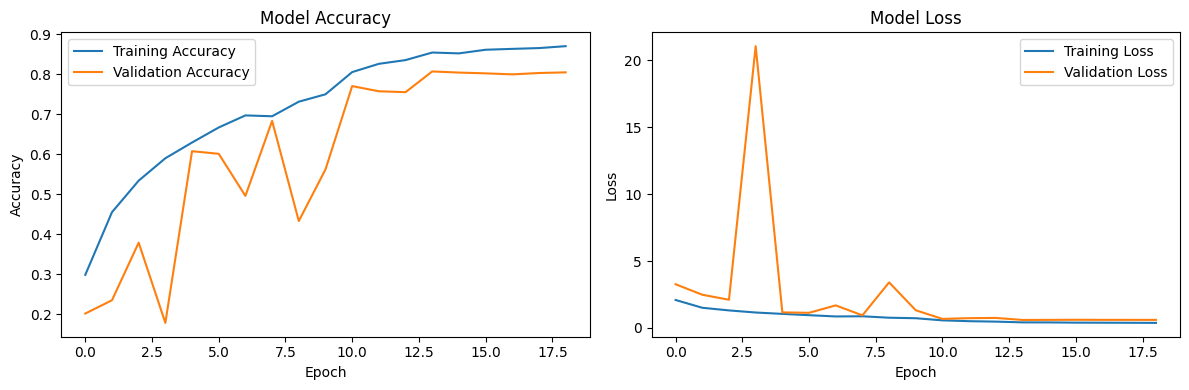

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8077 - loss: 0.5987 - top_2_accuracy: 0.9139


ValueError: too many values to unpack (expected 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


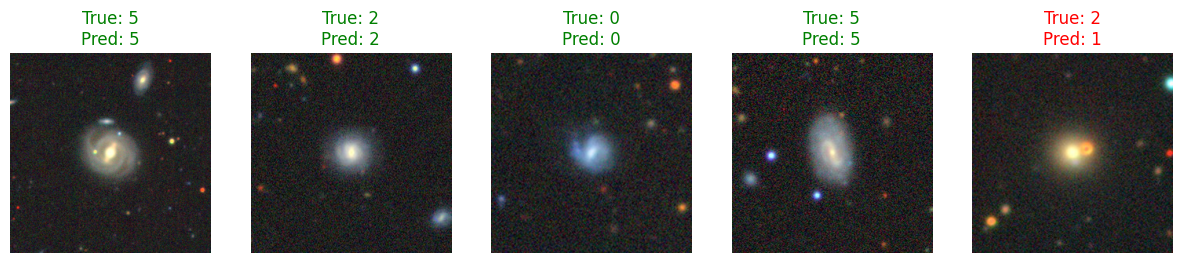

In [15]:
# Make and visualize predictions
def visualize_predictions(generator, model, num_images=5):
    images, true_labels = generator.__getitem__(0)
    predictions = model.predict(images)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        true_class = np.argmax(true_labels[i])
        pred_class = np.argmax(predictions[i])
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class}', color=color)
        plt.axis('off')
    plt.show()

visualize_predictions(val_generator, model)

In [16]:
# Save the model
model.save('galaxy_data/galaxy_classifier_model.h5')
print("Model saved successfully!")

Model saved successfully!
